# Импорт библиотек

In [24]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.7 MB/s eta 0:00:00


In [29]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.8 MB/s eta 0:00:00


In [88]:
import pandas as pd
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.tree import DecisionTreeRegressor
from scipy.special import expit
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import optuna
import xgboost as xgb


# Загрузка и работа с данными

In [70]:
archive_path = "/content/mai-ml-lab-2.zip"
extract_dir = "extracted_files"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

SyntaxError: incomplete input (<ipython-input-70-cd7eec3aa066>, line 6)

In [71]:
train = pd.read_csv("/content/extracted_files/train.csv")
test = pd.read_csv("/content/extracted_files/test.csv")

In [72]:
train.columns

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [73]:
train["smoking"].value_counts()

,count
smoking,
0.0,9501
1.0,5499


In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  int64  
 1   age                  15000 non-null  float64
 2   height(cm)           15000 non-null  float64
 3   weight(kg)           15000 non-null  float64
 4   waist(cm)            15000 non-null  float64
 5   eyesight(left)       15000 non-null  float64
 6   eyesight(right)      15000 non-null  float64
 7   hearing(left)        15000 non-null  float64
 8   hearing(right)       15000 non-null  float64
 9   systolic             15000 non-null  float64
 10  relaxation           15000 non-null  float64
 11  fasting blood sugar  15000 non-null  float64
 12  Cholesterol          15000 non-null  float64
 13  triglyceride         15000 non-null  float64
 14  HDL                  15000 non-null  float64
 15  LDL                  15000 non-null 

<ipython-input-75-3432a0df91bd>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette="coolwarm")


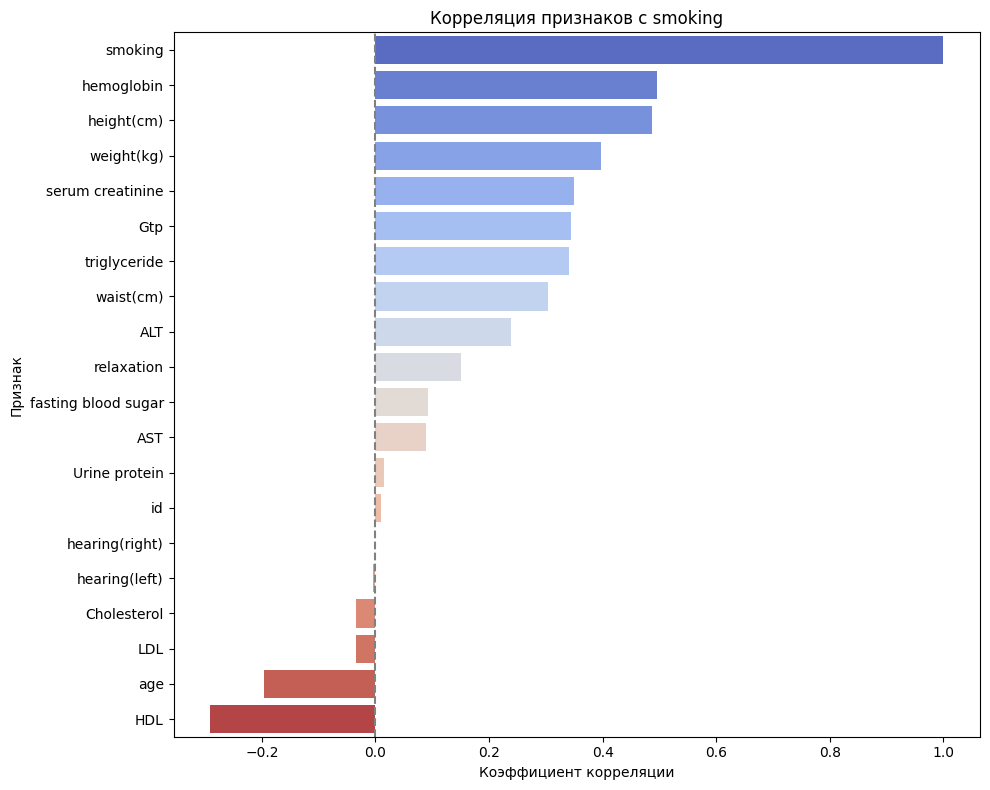

In [75]:
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
corr_matrix = train[numeric_cols].corr()
risk_corr = corr_matrix["smoking"].sort_values(ascending=False)
top_corr = pd.concat([risk_corr.head(10), risk_corr.tail(10)])
plt.figure(figsize=(10, 8))
sns.barplot(x=top_corr.values, y=top_corr.index, palette="coolwarm")
plt.title("Корреляция признаков с smoking")
plt.xlabel("Коэффициент корреляции")
plt.ylabel("Признак")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


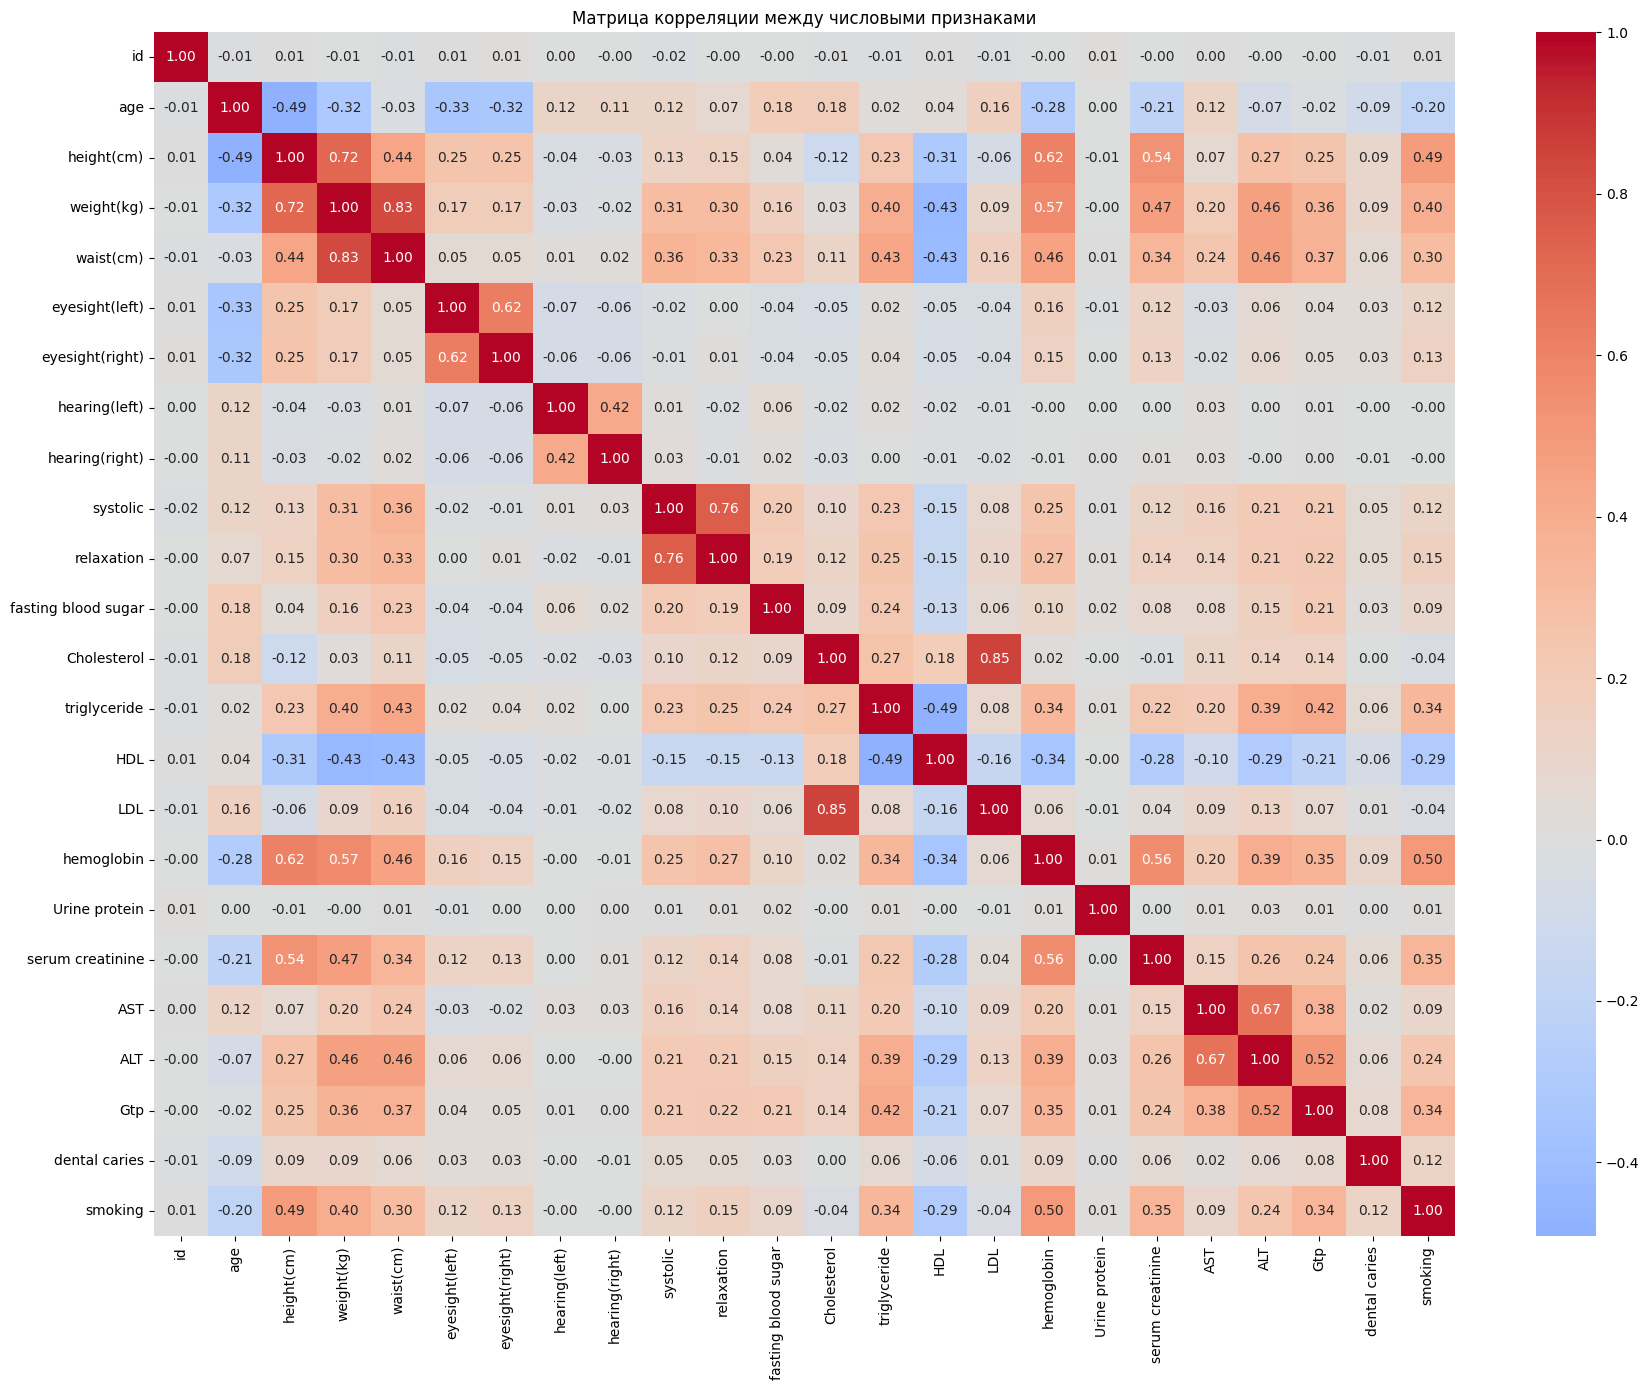

In [76]:
numeric_cols = train.select_dtypes(include='number')
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Матрица корреляции между числовыми признаками")
plt.tight_layout()
plt.show()


На основе даных из датасета можно сделать вывод, что можно создать новые параметры. Например, индекс массы тела, степени ожирения, различные сердечно-сосудистые показатели, а дисбаланс классов пофиксим при помощи добавления весов классам

In [77]:
train['height_m'] = train['height(cm)'] / 100
train['BMI'] = train['weight(kg)'] / (train['height_m'] ** 2)
train['WHtR'] = train['waist(cm)'] / train['height(cm)']
train['obesity_level'] = pd.cut(train['BMI'], bins=[0, 18.5, 24.9, 29.9, np.inf],labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
train['pulse_pressure'] = train['systolic'] - train['relaxation']
train['MAP'] = (train['systolic'] + 2 * train['relaxation']) / 3
train['hypertension_flag'] = ((train['systolic'] >= 140) | (train['relaxation'] >= 90)).astype(int)
train['cholesterol_ratio'] = train['Cholesterol'] / train['HDL']
train['atherogenic_index'] = (train['Cholesterol'] - train['HDL']) / train['HDL']
train['LDL_to_HDL'] = train['LDL'] / train['HDL']
train['TG_to_HDL'] = train['triglyceride'] / train['HDL']
train['diabetes_flag'] = pd.cut(train['fasting blood sugar'], bins=[0, 99, 125, np.inf], labels=[0, 1, 2]).astype(int)
train['AST_ALT_ratio'] = train['AST'] / train['ALT']
train['kidney_risk_flag'] = (train['serum creatinine'] > 1.3).astype(int)
train['eyesight_avg'] = (train['eyesight(left)'] + train['eyesight(right)']) / 2
train['hearing_avg'] = (train['hearing(left)'] + train['hearing(right)']) / 2
train['vision_issue_flag'] = ((train['eyesight(left)'] < 1.0) | (train['eyesight(right)'] < 1.0)).astype(int)
train['hearing_issue_flag'] = ((train['hearing(left)'] != 1.0) | (train['hearing(right)'] != 1.0)).astype(int)
train['risk_score'] = (
    (train['BMI'] > 30).astype(int) +
    (train['fasting blood sugar'] >= 126).astype(int) +
    (train['systolic'] >= 140).astype(int) +
    (train['Cholesterol'] > 240).astype(int) +
    (train['serum creatinine'] > 1.3).astype(int)
)
train['high_risk_flag'] = (train['risk_score'] >= 3).astype(int)


In [78]:
train

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,TG_to_HDL,diabetes_flag,AST_ALT_ratio,kidney_risk_flag,eyesight_avg,hearing_avg,vision_issue_flag,hearing_issue_flag,risk_score,high_risk_flag
0,0,55.0,150.0,50.0,73.0,0.8,1.0,1.0,1.0,122.0,...,0.790323,0,1.047619,0,0.90,1.0,1,0,0,0
1,1,50.0,160.0,60.0,79.6,1.0,0.8,1.0,1.0,124.0,...,1.013514,0,1.357143,0,0.90,1.0,1,0,0,0
2,2,55.0,145.0,50.0,73.0,1.2,1.2,1.0,1.0,110.0,...,1.090909,0,1.250000,0,1.20,1.0,0,0,0,0
3,3,40.0,175.0,80.0,83.2,0.9,1.0,1.0,1.0,99.0,...,2.052632,0,1.692308,0,0.95,1.0,1,0,0,0
4,4,30.0,170.0,70.0,79.5,1.2,1.2,1.0,1.0,119.0,...,1.775510,0,0.947368,0,1.20,1.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,40.0,170.0,65.0,82.0,1.0,1.0,1.0,1.0,127.0,...,1.238095,1,1.166667,0,1.00,1.0,0,0,0,0
14996,14996,35.0,175.0,70.0,76.9,1.5,1.5,1.0,1.0,112.0,...,2.044118,0,1.230769,0,1.50,1.0,0,0,0,0
14997,14997,40.0,170.0,75.0,90.0,2.0,1.5,1.0,1.0,130.0,...,4.021739,0,1.450000,0,1.75,1.0,0,0,0,0
14998,14998,60.0,175.0,85.0,100.0,0.7,0.8,1.0,1.0,110.0,...,2.785714,1,1.028571,0,0.75,1.0,1,0,0,0


In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   15000 non-null  int64   
 1   age                  15000 non-null  float64 
 2   height(cm)           15000 non-null  float64 
 3   weight(kg)           15000 non-null  float64 
 4   waist(cm)            15000 non-null  float64 
 5   eyesight(left)       15000 non-null  float64 
 6   eyesight(right)      15000 non-null  float64 
 7   hearing(left)        15000 non-null  float64 
 8   hearing(right)       15000 non-null  float64 
 9   systolic             15000 non-null  float64 
 10  relaxation           15000 non-null  float64 
 11  fasting blood sugar  15000 non-null  float64 
 12  Cholesterol          15000 non-null  float64 
 13  triglyceride         15000 non-null  float64 
 14  HDL                  15000 non-null  float64 
 15  LDL                

используеи OHE кодирование для категориального признака

In [80]:
encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded = encoder.fit_transform(train[["obesity_level"]])
encoded_columns = encoder.get_feature_names_out(["obesity_level"])
encoded_df = pd.DataFrame(encoded, columns=encoded_columns, index=train.index)
train = pd.concat([train.drop(columns=["obesity_level"]), encoded_df], axis=1)

In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         15000 non-null  int64  
 1   age                        15000 non-null  float64
 2   height(cm)                 15000 non-null  float64
 3   weight(kg)                 15000 non-null  float64
 4   waist(cm)                  15000 non-null  float64
 5   eyesight(left)             15000 non-null  float64
 6   eyesight(right)            15000 non-null  float64
 7   hearing(left)              15000 non-null  float64
 8   hearing(right)             15000 non-null  float64
 9   systolic                   15000 non-null  float64
 10  relaxation                 15000 non-null  float64
 11  fasting blood sugar        15000 non-null  float64
 12  Cholesterol                15000 non-null  float64
 13  triglyceride               15000 non-null  flo

In [82]:
X = train.drop(columns=['smoking'])
y = train['smoking']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Бэггинг


In [83]:
class MyBaggingClassifier:
    def __init__(self, base_estimator, n_estimators=10, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.models = []
        for i in range(self.n_estimators):
            X_sample, y_sample = resample(
                X, y, replace=True,
                random_state=self.random_state + i if self.random_state else None
            )
            model = clone(self.base_estimator)
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict_proba(self, X):
        probas = np.array([model.predict_proba(X) for model in self.models])
        return np.mean(probas, axis=0)

    def predict(self, X):
        avg_proba = self.predict_proba(X)
        return (avg_proba[:, 1] >= 0.5).astype(int)


In [84]:
my_bagging = MyBaggingClassifier(
    base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42
)
my_bagging.fit(X_train, y_train)
y_pred_proba_my = my_bagging.predict_proba(X_test)[:, 1]
auc_my = roc_auc_score(y_test, y_pred_proba_my)
sk_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42
)
sk_bagging.fit(X_train, y_train)
y_pred_proba_sk = sk_bagging.predict_proba(X_test)[:, 1]
auc_sk = roc_auc_score(y_test, y_pred_proba_sk)

print(f"ROC-AUC custom BaggingClassifier: {auc_my:.4f}")
print(f"ROC-AUC sklearn BaggingClassifier: {auc_sk:.4f}")

ROC-AUC custom BaggingClassifier: 0.8479
ROC-AUC sklearn BaggingClassifier: 0.8492


# Бустинг

In [85]:
class MyGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.init_prediction = None

    def _log_loss_gradient(self, y_true, y_pred_proba):
        return y_pred_proba - y_true

    def fit(self, X, y):
        y = y.astype(np.float64)
        p = np.clip(np.mean(y), 1e-5, 1 - 1e-5)
        self.init_prediction = np.log(p / (1 - p))
        f = np.full(y.shape, self.init_prediction)
        self.models = []
        for i in range(self.n_estimators):
            p = expit(f)
            grad = self._log_loss_gradient(y, p)
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, -grad)
            self.models.append(tree)
            f += self.learning_rate * tree.predict(X)

    def predict_proba(self, X):
        f = np.full((X.shape[0],), self.init_prediction)
        for tree in self.models:
            f += self.learning_rate * tree.predict(X)
        proba = expit(f)
        return np.vstack([1 - proba, proba]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)


In [86]:
my_gb = MyGradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=3)
my_gb.fit(X_train, y_train)
y_pred_my = my_gb.predict_proba(X_test)[:, 1]
auc_my = roc_auc_score(y_test, y_pred_my)

sk_gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=3)
sk_gb.fit(X_train, y_train)
y_pred_sk = sk_gb.predict_proba(X_test)[:, 1]
auc_sk = roc_auc_score(y_test, y_pred_sk)

xgb = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=3, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, y_pred_xgb)

lgbm = LGBMClassifier(n_estimators=500, learning_rate=0.1, max_depth=3, random_state=42)
lgbm.fit(X_train, y_train)
auc_lgbm = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1])

catboost = CatBoostClassifier(n_estimators=500, learning_rate=0.1, depth=3, verbose=0, random_state=42)
catboost.fit(X_train, y_train)
auc_cat = roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])

print(f"ROC-AUC custom GradientBoosting: {auc_my:.4f}")
print(f"ROC-AUC sklearn GradientBoosting: {auc_sk:.4f}")
print(f"ROC-AUC XGBoost: {auc_xgb:.4f}")
print(f"ROC-AUC LightGBM: {auc_lgbm:.4f}")
print(f"ROC-AUC CatBoost: {auc_cat:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3591
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

# Optuna

In [89]:
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
scale_pos_weight = neg_count / pos_count

def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "use_label_encoder": False,
        "verbosity": 0,
        "booster": "gbtree",
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "scale_pos_weight": scale_pos_weight
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train_split, y_train_split,
              eval_set=[(X_valid_split, y_valid_split)],
              verbose=False)

    preds = model.predict_proba(X_valid_split)[:, 1]
    auc = roc_auc_score(y_valid_split, preds)
    return auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

print("Best trial:")
print(f"ROC-AUC: {study.best_trial.value}")
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")



Best trial:
ROC-AUC: 0.88180023923445
Best hyperparameters:
  max_depth: 2
  learning_rate: 0.09928634993952619
  subsample: 0.7658329577753357
  colsample_bytree: 0.6941091583288895
  gamma: 3.0824575377516776
  reg_alpha: 2.579713192338805
  reg_lambda: 1.1223728269599316
  n_estimators: 982


In [90]:
best_params = study.best_trial.params
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "use_label_encoder": False,
    "verbosity": 0,
    "booster": "gbtree",
    "scale_pos_weight": scale_pos_weight
})
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6941091583288895, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=3.0824575377516776,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09928634993952619,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=982, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [91]:
y_pred = final_model.predict(X_test)
y_true = y_test

# Свои метрики

In [92]:
def custom_accuracy(y_true, y_pred):
    correct = (y_true == y_pred).sum()
    total = len(y_true)
    return correct / total

def custom_precision(y_true, y_pred):
    true_positives = ((y_true == 1) & (y_pred == 1)).sum()
    predicted_positives = (y_pred == 1).sum()
    if predicted_positives == 0:
        return 0.0
    return true_positives / predicted_positives

def custom_recall(y_true, y_pred):
    true_positives = ((y_true == 1) & (y_pred == 1)).sum()
    actual_positives = (y_true == 1).sum()
    if actual_positives == 0:
        return 0.0
    return true_positives / actual_positives

def custom_f1_score(y_true, y_pred):
    precision = custom_precision(y_true, y_pred)
    recall = custom_recall(y_true, y_pred)
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

In [93]:
print("Custom Accuracy:", custom_accuracy(y_true, y_pred))
print("sklearn Accuracy:", accuracy_score(y_true, y_pred))
print()
print("Custom Precision:", custom_precision(y_true, y_pred))
print("sklearn Precision:", precision_score(y_true, y_pred))
print()
print("Custom Recall:", custom_recall(y_true, y_pred))
print("sklearn Recall:", recall_score(y_true, y_pred))
print()
print("Custom F1-score:", custom_f1_score(y_true, y_pred))
print("sklearn F1-score:", f1_score(y_true, y_pred))

Custom Accuracy: 0.786
sklearn Accuracy: 0.786

Custom Precision: 0.6577134986225895
sklearn Precision: 0.6577134986225895

Custom Recall: 0.8681818181818182
sklearn Recall: 0.8681818181818182

Custom F1-score: 0.7484326018808777
sklearn F1-score: 0.7484326018808778


# Обработка тестового датасета и создание сабмит файла

In [94]:
test['height_m'] = test['height(cm)'] / 100
test['BMI'] = test['weight(kg)'] / (test['height_m'] ** 2)
test['WHtR'] = test['waist(cm)'] / test['height(cm)']
test['obesity_level'] = pd.cut(test['BMI'], bins=[0, 18.5, 24.9, 29.9, np.inf],
                                labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
test['pulse_pressure'] = test['systolic'] - test['relaxation']
test['MAP'] = (test['systolic'] + 2 * test['relaxation']) / 3
test['hypertension_flag'] = ((test['systolic'] >= 140) | (test['relaxation'] >= 90)).astype(int)
test['cholesterol_ratio'] = test['Cholesterol'] / test['HDL']
test['atherogenic_index'] = (test['Cholesterol'] - test['HDL']) / test['HDL']
test['LDL_to_HDL'] = test['LDL'] / test['HDL']
test['TG_to_HDL'] = test['triglyceride'] / test['HDL']
test['diabetes_flag'] = pd.cut(test['fasting blood sugar'], bins=[0, 99, 125, np.inf], labels=[0, 1, 2]).astype(int)
test['AST_ALT_ratio'] = test['AST'] / test['ALT']
test['kidney_risk_flag'] = (test['serum creatinine'] > 1.3).astype(int)
test['eyesight_avg'] = (test['eyesight(left)'] + test['eyesight(right)']) / 2
test['hearing_avg'] = (test['hearing(left)'] + test['hearing(right)']) / 2
test['vision_issue_flag'] = ((test['eyesight(left)'] < 1.0) | (test['eyesight(right)'] < 1.0)).astype(int)
test['hearing_issue_flag'] = ((test['hearing(left)'] != 1.0) | (test['hearing(right)'] != 1.0)).astype(int)
test['risk_score'] = (
    (test['BMI'] > 30).astype(int) +
    (test['fasting blood sugar'] >= 126).astype(int) +
    (test['systolic'] >= 140).astype(int) +
    (test['Cholesterol'] > 240).astype(int) +
    (test['serum creatinine'] > 1.3).astype(int)
)
test['high_risk_flag'] = (test['risk_score'] >= 3).astype(int)


In [95]:
encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded = encoder.fit_transform(test[["obesity_level"]])
encoded_columns = encoder.get_feature_names_out(["obesity_level"])
encoded_df = pd.DataFrame(encoded, columns=encoded_columns, index=test.index)
test = pd.concat([test.drop(columns=["obesity_level"]), encoded_df], axis=1)

In [96]:
X_new = test

In [97]:
y_test_pred_proba = final_model.predict_proba(X_new)[:, 1]

In [98]:
sub = pd.DataFrame()

In [99]:
test['smoking'] = y_test_pred_proba

In [100]:
test

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,hearing_avg,vision_issue_flag,hearing_issue_flag,risk_score,high_risk_flag,obesity_level_Normal,obesity_level_Obese,obesity_level_Overweight,obesity_level_Underweight,smoking
0,15000,40.0,155.0,45.0,64.0,0.9,0.9,1.0,1.0,109.0,...,1.0,1,0,0,0,1.0,0.0,0.0,0.0,0.049217
1,15001,45.0,175.0,90.0,101.0,1.0,1.2,1.0,1.0,130.0,...,1.0,0,0,0,0,0.0,0.0,1.0,0.0,0.923085
2,15002,40.0,165.0,60.0,78.0,1.5,1.5,1.0,1.0,107.0,...,1.0,0,0,0,0,1.0,0.0,0.0,0.0,0.163861
3,15003,35.0,170.0,60.0,84.5,1.0,1.0,1.0,1.0,124.0,...,1.0,0,0,0,0,1.0,0.0,0.0,0.0,0.868109
4,15004,40.0,155.0,45.0,68.5,1.0,1.0,1.0,1.0,109.0,...,1.0,0,0,0,0,1.0,0.0,0.0,0.0,0.008674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,40.0,160.0,50.0,71.0,1.0,1.0,1.0,1.0,99.0,...,1.0,0,0,0,0,1.0,0.0,0.0,0.0,0.098812
9996,24996,70.0,165.0,65.0,85.0,0.8,0.8,1.0,1.0,112.0,...,1.0,1,0,0,0,1.0,0.0,0.0,0.0,0.349928
9997,24997,35.0,175.0,70.0,86.0,1.5,1.2,1.0,1.0,115.0,...,1.0,0,0,0,0,1.0,0.0,0.0,0.0,0.760184
9998,24998,40.0,165.0,75.0,88.0,0.8,0.3,1.0,1.0,126.0,...,1.0,1,0,0,0,0.0,0.0,1.0,0.0,0.736554


In [101]:
sub = test[["id", "smoking"]]

In [102]:
sub

,id,smoking
0,15000,0.049217
1,15001,0.923085
2,15002,0.163861
3,15003,0.868109
4,15004,0.008674
...,...,...
9995,24995,0.098812
9996,24996,0.349928
9997,24997,0.760184
9998,24998,0.736554


In [103]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       10000 non-null  int64  
 1   smoking  10000 non-null  float32
dtypes: float32(1), int64(1)
memory usage: 117.3 KB


In [104]:
sub.to_csv('sub_true_2.csv', index=False)